In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import gc
import myutil



In [8]:
class lgbWrapper():
    def __init__(self, seed=0, params=None):
        return
    
    def init_model(self):
#The setting used in initial result
#ref: https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/code#L294
        self.clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
# The setting used obtained after the bayesian optimization using entire dataset
#         self.clf = LGBMClassifier(
#             n_estimators=10000,
#             learning_rate=0.05,
#             num_leaves=38.7570,
#             colsample_bytree=.8,
#             subsample=.9,
#             max_depth=5.0196,
#             reg_alpha=.1,
#             reg_lambda=.1,
#             min_split_gain=.0393,
#             min_child_weight=46.8416,
#             silent=-1,
#             verbose=-1,
#         )

# The setting used obtained after the bayesian optimization using undersampled dataset
#         self.clf = LGBMClassifier(
#             n_estimators=10000,
#             learning_rate=0.05,
#             num_leaves=23,
#             colsample_bytree=.8,
#             subsample=.9,
#             max_depth=8,
#             reg_alpha=.1,
#             reg_lambda=.1,
#             min_split_gain=0.0304,
#             min_child_weight=49.2236,
#             feature_fraction=0.1259,
#             bagging_fraction= 0.8340,
#             lambda_l1=4.9544,
#             lambda_l2=0.0229,
#             silent=-1,
#             verbose=-1,
#         )
        return    
    def __str__(self):
        return 'lgb'

    def train(self, trn_x, trn_y):
        self.clf.fit(trn_x, trn_y, verbose=100)

    def predict(self, x):
        result = self.clf.predict_proba(x, num_iteration=self.clf.best_iteration_)[:, 1]
        return result
    
    def get_coef(self):
        return self.clf.feature_importances_

lgb = lgbWrapper()

In [3]:
data, test, y = myutil.get_train_test_label()


train datasset shape: (307511, 828)
test datasset shape: (48744, 828)


In [4]:
oof_preds, test_preds, importances, folds = myutil.cross_validation(data, test, y, lgb)

start at: 2018-11-30 22:48:09.609741
Fold  1 AUC : 0.785396
Fold  2 AUC : 0.782126
Fold  3 AUC : 0.783657
Fold  4 AUC : 0.784734
Fold  5 AUC : 0.780090
Full AUC score 0.783181
Duration: 0:19:23.448060


lightgbm


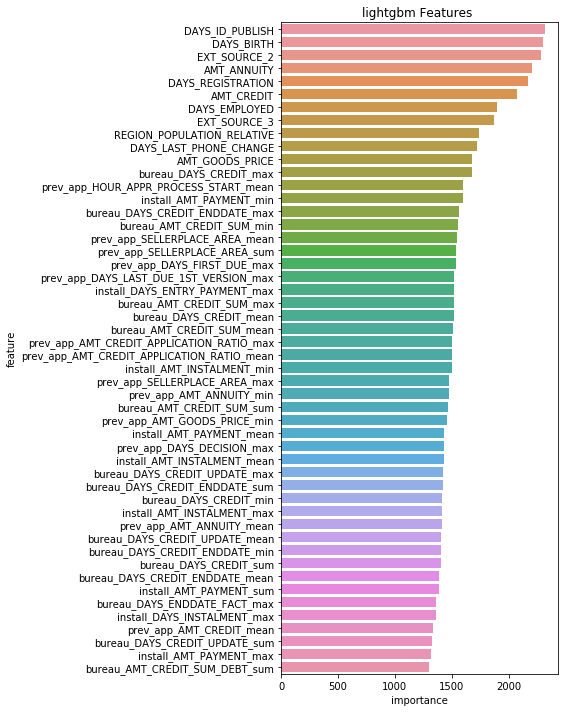

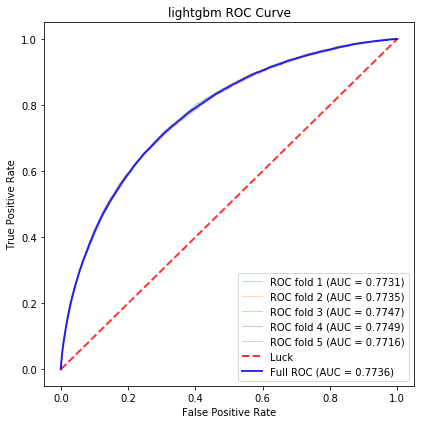

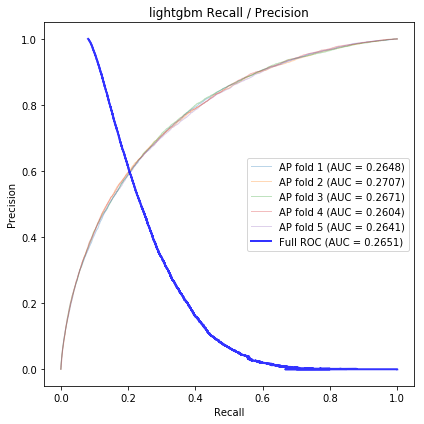

In [7]:
title = 'lightgbm'
myutil.report(test_preds, folds, importances, data, y, oof_preds, title, True)

In [5]:
#save the feature importances
cols_all = importances[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False).index
cols_all_df = pd.DataFrame(cols_all, columns = ['feature'])
cols_all_df.to_csv('lgbm_selectFeature_o.csv', index=False)

In [ ]:
#run this function to test number of features in step size of 50
myutil.feature_select_cross_validation(importances, data, test, y, lgb)

number of iteration: 16
1
Fold  1 AUC : 0.758927
Fold  2 AUC : 0.762300
Fold  3 AUC : 0.759229
Fold  4 AUC : 0.759371
Fold  5 AUC : 0.753989
Full AUC score 0.758756
2
Fold  1 AUC : 0.769594
Fold  2 AUC : 0.772097
Fold  3 AUC : 0.772333
Fold  4 AUC : 0.772736
Fold  5 AUC : 0.764526
Full AUC score 0.770252
3
Fold  1 AUC : 0.774369
Fold  2 AUC : 0.775179
Fold  3 AUC : 0.773682
Fold  4 AUC : 0.772821
Fold  5 AUC : 0.767541
Full AUC score 0.772710
4
Fold  1 AUC : 0.774994
Fold  2 AUC : 0.774449
Fold  3 AUC : 0.774476
Fold  4 AUC : 0.774892
Fold  5 AUC : 0.769674
Full AUC score 0.773676
5
Fold  1 AUC : 0.777413
Fold  2 AUC : 0.777213
Fold  3 AUC : 0.777665
Fold  4 AUC : 0.778204
Fold  5 AUC : 0.772969
Full AUC score 0.776680
6
Fold  1 AUC : 0.778969
Fold  2 AUC : 0.778681
Fold  3 AUC : 0.779444
Fold  4 AUC : 0.779865
Fold  5 AUC : 0.773124
Full AUC score 0.778007
7
Fold  1 AUC : 0.782069
Fold  2 AUC : 0.781571
Fold  3 AUC : 0.782125


In [ ]:
oof_preds_us, test_preds_us, importances_us, folds_us = myutil.cross_validation_undersample(data, test, y, lgb)

lightgbm_undersample


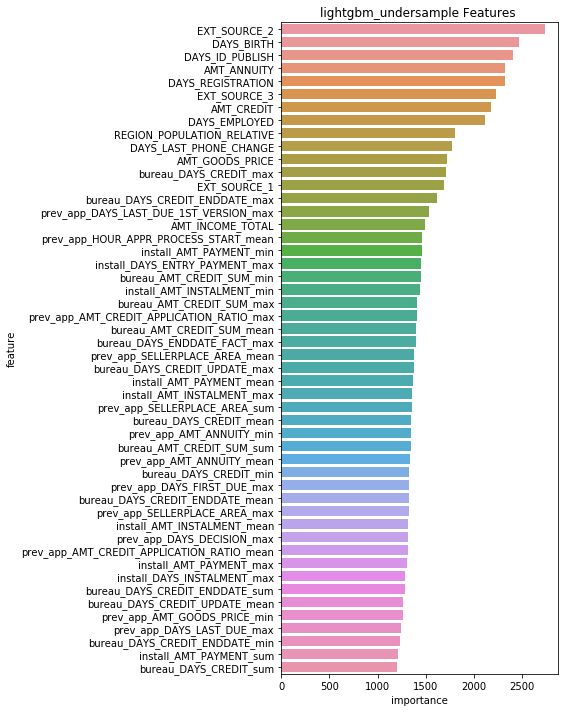

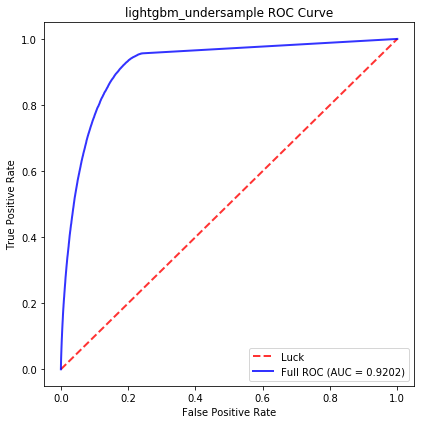

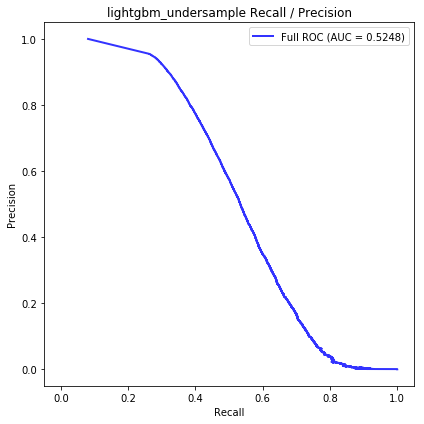

In [7]:
title = 'lightgbm_undersample'
myutil.report(test_preds_us, folds_us, importances_us, data, y, oof_preds_us, title, False)

In [ ]:
#run this function to test number of features in step size of 50
myutil.feature_select_cross_validation_undersample(importances_us, data, test, y, lgb)

In [10]:
cols_all = importances_us[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False).index
cols_all_df = pd.DataFrame(cols_all, columns = ['feature'])
cols_all_df.to_csv('lgbm_selectFeature_us.csv', index=False)

In [ ]:
fs_df = pd.read_csv('lgbm_selectFeature_o.csv')
features = fs_df['feature'].values.tolist()
features = features[:550]

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
best_param = myutil.opt(features, data)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
[200]	cv_agg's auc: 0.783962 + 0.00255043
[400]	cv_agg's auc: 0.78681 + 0.00267399
    1 | 02m03s |    0.78706 |             0.9583 |         2.6555 |             0.6167 |      6.3992 |      2.6456 |      8.8619 |            21.1779 |           0.3092 |      48.4169 | 
[200]	cv_agg's auc: 0.784371 + 0.00153535
[400]	cv_agg's auc: 0.786918 + 0.00176711
[600]	cv_agg's auc: 0.786723 + 0.00206685
    2 | 01m46s |    0.78703 |             0.9058 |         1.3841 |             0.4501 |      1.4335 |      7.7423 |      7.7870 |            24.6664 |           0.3064 |      60.0633 | 
[200]	cv_agg's auc: 0.781126 

In [ ]:
fs_df = pd.read_csv('lgbm_selectFeature_us.csv')
features = fs_df['feature'].values.tolist()
features = features[:550]

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
best_param = myutil.opt(features, data)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
[200]	cv_agg's auc: 0.78105 + 0.00315139
[400]	cv_agg's auc: 0.782547 + 0.00277308
    1 | 00m30s |    0.78255 |             0.9583 |         2.6555 |             0.6167 |      6.3992 |      2.6456 |      8.8619 |            21.1779 |           0.3092 |      48.4169 | 
[200]	cv_agg's auc: 0.778257 + 0.00229144
[400]	cv_agg's auc: 0.778705 + 0.00255423
    2 | 00m26s |    0.77916 |             0.9058 |         1.3841 |             0.4501 |      1.4335 |      7.7423 |      7.7870 |            24.6664 |           0.3064 |      60.0633 | 
[200]	cv_agg's auc: 0.777582 + 0.000508397
[400]	cv_agg's auc: 0.780733